# 04 - Manhattan Subway Temporal Pattern Analysis
_Comprehensive Time-Based Ridership Pattern Discovery_

---

**Objective:**  
Analyze Manhattan subway ridership patterns across temporal dimensions to identify predictable trends and inform feature engineering.

**Input Dataset:**  
`weather_ridership_integrated_2024.parquet`  
→ 1,052,709 records · 121 station complexes · 23 features

**Goals:**
- Identify hourly ridership trends (e.g. rush hours, off-peak)
- Analyze daily patterns (weekday vs weekend behavior)
- Examine seasonal and monthly effects
- Investigate station-level temporal variation
- Detect holiday and special event impacts
- Generate validated temporal insights for feature engineering

**Output:**  
A validated set of time-based pattern definitions saved to:  
`../data/processed/analysis/temporal_patterns.json`

In [1]:
# =========================================
# Setup and Configuration
# =========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from datetime import datetime, timedelta
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Plotting configuration
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Header
print("Manhattan Subway Temporal Pattern Analysis")
print("=" * 60)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("Objective: Discover temporal ridership patterns for predictive modeling")
print("=" * 60)


Manhattan Subway Temporal Pattern Analysis
Analysis Date: 2025-07-28 19:48:57
Objective: Discover temporal ridership patterns for predictive modeling


In [2]:
# =========================================
# 1. LOAD INTEGRATED WEATHER-RIDERSHIP DATA
# =========================================

print("\n" + "=" * 60)
print("1. LOADING INTEGRATED DATASET")
print("=" * 60)

# Directory paths
PROJECT_DIR = Path(".").resolve().parents[0]
DATA_DIR = PROJECT_DIR / "data"
PROCESSED_DIR = DATA_DIR / "processed"
INTEGRATION_DIR = PROCESSED_DIR / "integration"
ANALYSIS_DIR = PROCESSED_DIR / "analysis"
ANALYSIS_DIR.mkdir(parents=True, exist_ok=True)

# Input file path
INTEGRATED_FILE = INTEGRATION_DIR / "weather_ridership_integrated_2024.parquet"

# Load data
if not INTEGRATED_FILE.exists():
    raise FileNotFoundError(f"Integrated dataset not found: {INTEGRATED_FILE}")

print(f"Loading integrated dataset: {INTEGRATED_FILE.name}")
df = pd.read_parquet(INTEGRATED_FILE)
df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'])

# Summary
print(f"Dataset loaded successfully:")
print(f"• Records: {len(df):,}")
print(f"• Stations: {df['station_complex_id'].nunique()}")
print(f"• Features: {len(df.columns)}")
print(f"• Date range: {df['transit_timestamp'].min()} to {df['transit_timestamp'].max()}")
print(f"• Max ridership: {df['ridership'].max():,}")
print(f"• Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Data quality check
print(f"• Missing ridership values: {df['ridership'].isna().sum()}")
print(f"• Zero ridership records: {(df['ridership'] == 0).sum()}")

# Sample preview
print("\nSample data:")
sample_cols = ['station_complex_id', 'transit_timestamp', 'ridership', 'temp', 'weather_main', 'is_cbd']
available_cols = [col for col in sample_cols if col in df.columns]
print(df[available_cols].head(3))



1. LOADING INTEGRATED DATASET
Loading integrated dataset: weather_ridership_integrated_2024.parquet
Dataset loaded successfully:
• Records: 1,052,709
• Stations: 121
• Features: 23
• Date range: 2024-01-01 00:00:00 to 2024-12-31 23:00:00
• Max ridership: 21,479
• Memory usage: 389.0 MB
• Missing ridership values: 0
• Zero ridership records: 0

Sample data:
   station_complex_id   transit_timestamp  ridership  temp weather_main  \
0                   8 2024-01-01 00:00:00       1141  5.75         Rain   
1                   8 2024-01-01 01:00:00        351  5.43         Rain   
2                   8 2024-01-01 02:00:00         94  5.45       Clouds   

   is_cbd  
0       1  
1       1  
2       1  


In [3]:
# =========================================
# Dataset Overview and Basic Statistics
# =========================================

print("\n" + "-" * 60)
print("DATASET OVERVIEW")
print("-" * 60)

# Basic ridership statistics
ridership_stats = df['ridership'].describe()
print("\nRidership distribution:")
print(ridership_stats)

# Temporal coverage
total_hours = (df['transit_timestamp'].max() - df['transit_timestamp'].min()).total_seconds() / 3600
unique_hours = df['transit_timestamp'].nunique()
coverage = (unique_hours / total_hours) * 100

print("\nTemporal coverage:")
print(f"• Total possible hours in 2024: {total_hours:.0f}")
print(f"• Unique hourly timestamps:     {unique_hours:,}")
print(f"• Coverage:                     {coverage:.1f}%")

# Station distribution
stations_per_record = df.groupby('station_complex_id').size().describe()
print("\nStation coverage:")
print(f"• Unique stations:              {df['station_complex_id'].nunique()}")
print(f"• Records per station:")
print(f"   - Min:   {stations_per_record['min']:.0f}")
print(f"   - Max:   {stations_per_record['max']:.0f}")
print(f"   - Mean:  {stations_per_record['mean']:.0f}")

# Key feature availability check
print("\nKey feature availability:")
key_features = ['hour', 'day_of_week', 'month', 'is_cbd', 'temp', 'weather_main']
for feature in key_features:
    status = "Available" if feature in df.columns else "Missing"
    print(f"• {feature:<15}: {status}")

# Initialize results dictionary
analysis_results = {
    'dataset_overview': {
        'total_records': len(df),
        'unique_stations': df['station_complex_id'].nunique(),
        'unique_hours': unique_hours,
        'max_ridership': int(df['ridership'].max()),
        'mean_ridership': float(df['ridership'].mean()),
        'temporal_coverage_pct': float(coverage)
    }
}


------------------------------------------------------------
DATASET OVERVIEW
------------------------------------------------------------

Ridership distribution:
count   1052709.00
mean        643.55
std        1138.36
min           1.00
25%          70.00
50%         284.00
75%         721.00
max       21479.00
Name: ridership, dtype: Float64

Temporal coverage:
• Total possible hours in 2024: 8783
• Unique hourly timestamps:     8,783
• Coverage:                     100.0%

Station coverage:
• Unique stations:              121
• Records per station:
   - Min:   7956
   - Max:   8783
   - Mean:  8700

Key feature availability:
• hour           : Available
• day_of_week    : Available
• month          : Available
• is_cbd         : Available
• temp           : Available
• weather_main   : Available


In [4]:
# =========================================
# 2. Hourly Pattern Analysis
# =========================================

print("\n" + "=" * 60)
print("2. HOURLY PATTERN ANALYSIS")
print("=" * 60)

# Aggregate hourly ridership statistics
hourly_patterns = df.groupby('hour')['ridership'].agg(['sum', 'mean', 'count', 'std']).round(2)
hourly_patterns.columns = ['total_ridership', 'avg_ridership', 'record_count', 'std_ridership']

print("Hourly ridership summary statistics:")
print(hourly_patterns)

# Identify peak periods using average ridership
hourly_ridership = hourly_patterns['avg_ridership']

# AM Rush: Define peak hours in early morning
am_peak_hour = hourly_ridership[5:12].idxmax()
am_rush_threshold = hourly_ridership[am_peak_hour] * 0.85
am_rush = hourly_ridership.loc[6:10][hourly_ridership.loc[6:10] >= am_rush_threshold].index.tolist()

# PM Rush: Define peak hours in the evening
pm_peak_hour = hourly_ridership[12:22].idxmax()
pm_rush_threshold = hourly_ridership[pm_peak_hour] * 0.85
pm_rush = hourly_ridership.loc[14:19][hourly_ridership.loc[14:19] >= pm_rush_threshold].index.tolist()

rush_hours = sorted(am_rush + pm_rush)
off_peak_hours = [h for h in range(24) if h not in rush_hours]

# Print results
print("\nRush Hour Identification:")
print(f"AM peak hour:          {am_peak_hour} ({hourly_ridership[am_peak_hour]:.0f})")
print(f"PM peak hour:          {pm_peak_hour} ({hourly_ridership[pm_peak_hour]:.0f})")
print(f"AM rush threshold:     {am_rush_threshold:.0f}")
print(f"PM rush threshold:     {pm_rush_threshold:.0f}")
print(f"AM rush hours:         {am_rush}")
print(f"PM rush hours:         {pm_rush}")
print(f"Total rush hours:      {rush_hours}")
print(f"Off-peak hours:        {off_peak_hours}")

# Calculate rush hour effect
rush_avg = hourly_patterns.loc[rush_hours, 'avg_ridership'].mean() if rush_hours else 0
off_peak_avg = hourly_patterns.loc[off_peak_hours, 'avg_ridership'].mean() if off_peak_hours else 0
rush_factor = rush_avg / off_peak_avg if off_peak_avg > 0 else 0

print("\nRush Hour Effect:")
print(f"Average rush hour ridership:   {rush_avg:.0f}")
print(f"Average off-peak ridership:    {off_peak_avg:.0f}")
print(f"Rush-to-off-peak ratio:        {rush_factor:.2f}x")

# Store results for export/feature metadata
analysis_results['hourly_patterns'] = {
    'rush_hours': rush_hours,
    'am_rush': am_rush,
    'pm_rush': pm_rush,
    'off_peak_hours': off_peak_hours,
    'rush_factor': float(rush_factor),
    'am_peak_hour': int(am_peak_hour),
    'pm_peak_hour': int(pm_peak_hour),
    'am_rush_threshold': float(am_rush_threshold),
    'pm_rush_threshold': float(pm_rush_threshold)
}



2. HOURLY PATTERN ANALYSIS
Hourly ridership summary statistics:
      total_ridership  avg_ridership  record_count  std_ridership
hour                                                             
0             7391904         169.60         43585         293.82
1             3018574          69.81         43238         135.47
2             1582503          37.07         42695          72.19
3             1066805          24.97         42717          41.27
4             1367402          31.38         43571          39.39
5             4185813          95.10         44016         212.96
6            11232615         254.96         44057         551.12
7            25996590         589.76         44080        1021.79
8            40535663         919.82         44069        1449.20
9            31387125         712.24         44068        1033.84
10           25371796         575.86         44059         706.83
11           27088496         614.59         44076         692.42
12         

In [5]:
# =========================================
# 3. Daily Pattern Analysis
# =========================================

print("\n" + "=" * 60)
print("3. DAILY PATTERN ANALYSIS")
print("=" * 60)

# Add helpful columns
df['day_name'] = df['transit_timestamp'].dt.day_name()
df['is_weekend'] = df['day_of_week'].isin([5, 6])  # Saturday=5, Sunday=6

# Daily ridership stats
daily_patterns = df.groupby(['day_of_week', 'day_name'])['ridership'].agg(['sum', 'mean', 'count']).round(2)
daily_patterns.columns = ['total_ridership', 'avg_ridership', 'record_count']
print("Daily ridership summary:")
print(daily_patterns)

# Weekend vs weekday summary
weekend_vs_weekday = df.groupby('is_weekend')['ridership'].agg(['sum', 'mean', 'count']).round(2)
weekend_vs_weekday.index = ['Weekday', 'Weekend']
weekend_vs_weekday.columns = ['total_ridership', 'avg_ridership', 'record_count']
print("\nWeekday vs Weekend comparison:")
print(weekend_vs_weekday)

# Calculate weekend factor
weekday_avg = weekend_vs_weekday.loc['Weekday', 'avg_ridership']
weekend_avg = weekend_vs_weekday.loc['Weekend', 'avg_ridership']
weekend_factor = weekend_avg / weekday_avg if weekday_avg > 0 else np.nan

print("\nWeekend Insights:")
print(f"Weekday avg ridership: {weekday_avg:.0f}")
print(f"Weekend avg ridership: {weekend_avg:.0f}")
print(f"Weekend factor:        {weekend_factor:.2f}x")

# Identify strongest/weakest average ridership day
strongest_day = daily_patterns['avg_ridership'].idxmax()
weakest_day = daily_patterns['avg_ridership'].idxmin()
strongest_label = strongest_day[1]
weakest_label = weakest_day[1]
print(f"Strongest day: {strongest_label} ({daily_patterns.loc[strongest_day, 'avg_ridership']:.0f})")
print(f"Weakest day:   {weakest_label} ({daily_patterns.loc[weakest_day, 'avg_ridership']:.0f})")

# Hourly comparison between weekday and weekend
weekday_hourly = df[~df['is_weekend']].groupby('hour')['ridership'].mean()
weekend_hourly = df[df['is_weekend']].groupby('hour')['ridership'].mean()

hourly_comparison = pd.DataFrame({
    'weekday_avg': weekday_hourly,
    'weekend_avg': weekend_hourly
})
hourly_comparison['weekend_ratio'] = (
    hourly_comparison['weekend_avg'] / hourly_comparison['weekday_avg']
).replace([np.inf, -np.inf], np.nan).round(2)

print("\nHourly pattern comparison (weekday vs weekend):")
print(hourly_comparison.round(0))

# Rush hour behavior by day type
weekday_rush_avg = df[~df['is_weekend'] & df['hour'].isin(rush_hours)]['ridership'].mean()
weekend_rush_avg = df[df['is_weekend'] & df['hour'].isin(rush_hours)]['ridership'].mean()
rush_weekend_factor = weekend_rush_avg / weekday_rush_avg if weekday_rush_avg > 0 else np.nan

print("\nRush Hour Comparison by Day Type:")
print(f"Weekday rush hour avg: {weekday_rush_avg:.0f}")
print(f"Weekend rush hour avg: {weekend_rush_avg:.0f}")
print(f"Weekend rush factor:   {rush_weekend_factor:.2f}x")

# Store results
analysis_results['daily_patterns'] = {
    'weekend_factor': float(weekend_factor),
    'weekday_avg': float(weekday_avg),
    'weekend_avg': float(weekend_avg),
    'strongest_day': strongest_label,
    'weakest_day': weakest_label,
    'rush_weekend_factor': float(rush_weekend_factor),
    'daily_averages': {day[1]: float(avg) for day, avg in daily_patterns['avg_ridership'].items()}
}



3. DAILY PATTERN ANALYSIS
Daily ridership summary:
                       total_ridership  avg_ridership  record_count
day_of_week day_name                                               
0           Monday            98711592         645.94        152818
1           Tuesday          114601838         749.29        152948
2           Wednesday        114439941         762.38        150109
3           Thursday         113573963         756.85        150062
4           Friday           102491432         682.91        150080
5           Saturday          74326381         500.54        148493
6           Sunday            59328303         400.33        148199

Weekday vs Weekend comparison:
         total_ridership  avg_ridership  record_count
Weekday        543818766         719.32        756017
Weekend        133654684         450.48        296692

Weekend Insights:
Weekday avg ridership: 719
Weekend avg ridership: 450
Weekend factor:        0.63x
Strongest day: Wednesday (762)
Weakest d

In [6]:
# =========================================
# 4. Monthly and Seasonal Pattern Analysis
# =========================================

print("\n" + "=" * 60)
print("4. MONTHLY AND SEASONAL PATTERN ANALYSIS")
print("=" * 60)

# Month names for readability
month_names = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}

# Ensure month column exists
if 'month' not in df.columns:
    df['month'] = df['transit_timestamp'].dt.month
df['month_name'] = df['month'].map(month_names)

# Monthly ridership aggregation
monthly_patterns = df.groupby(['month', 'month_name'])['ridership'].agg(['sum', 'mean', 'count']).round(2)
monthly_patterns.columns = ['total_ridership', 'avg_ridership', 'record_count']
monthly_patterns = monthly_patterns.reset_index()

print("Monthly ridership summary:")
print(monthly_patterns)

# Compute seasonal factors vs annual average
annual_avg = df['ridership'].mean()
monthly_patterns['seasonal_factor'] = (monthly_patterns['avg_ridership'] / annual_avg).round(3)

print(f"\nSeasonal factors relative to annual average of {annual_avg:.0f}:")
for _, row in monthly_patterns.iterrows():
    month_name = row['month_name']
    factor = row['seasonal_factor']
    interpretation = "above average" if factor > 1.0 else "below average"
    print(f"{month_name}: {factor:.3f} ({interpretation})")

# High and low months by threshold
high_months = monthly_patterns[monthly_patterns['seasonal_factor'] > 1.05]['month_name'].tolist()
low_months = monthly_patterns[monthly_patterns['seasonal_factor'] < 0.95]['month_name'].tolist()

# Peak and lowest seasonal months
peak_month = monthly_patterns.loc[monthly_patterns['seasonal_factor'].idxmax()]
lowest_month = monthly_patterns.loc[monthly_patterns['seasonal_factor'].idxmin()]
seasonal_range = peak_month['seasonal_factor'] - lowest_month['seasonal_factor']

print("\nSeasonal Insights:")
print(f"High ridership months (>5% above average): {high_months}")
print(f"Low ridership months (<5% below average): {low_months}")
print(f"Peak month: {peak_month['month_name']} ({peak_month['seasonal_factor']:.3f})")
print(f"Lowest month: {lowest_month['month_name']} ({lowest_month['seasonal_factor']:.3f})")
print(f"Seasonal variation range: {seasonal_range:.3f} ({seasonal_range * 100:.1f} percentage points)")

# Group months into seasons
season_mapping = {
    'Winter': ['December', 'January', 'February'],
    'Spring': ['March', 'April', 'May'],
    'Summer': ['June', 'July', 'August'],
    'Fall':   ['September', 'October', 'November']
}
df['season'] = df['month_name'].map({
    month: season for season, months in season_mapping.items() for month in months
})

# Seasonal group summary
seasonal_analysis = df.groupby('season')['ridership'].agg(['mean', 'count']).round(2)
seasonal_analysis['seasonal_factor'] = (seasonal_analysis['mean'] / annual_avg).round(3)

print("\nSeasonal Group Summary:")
print(seasonal_analysis)

# Store results
analysis_results['seasonal_patterns'] = {
    'annual_average': float(annual_avg),
    'high_months': high_months,
    'low_months': low_months,
    'peak_month': str(peak_month['month_name']),
    'lowest_month': str(lowest_month['month_name']),
    'seasonal_range': float(seasonal_range),
    'monthly_factors': {
        str(row['month_name']): float(row['seasonal_factor'])
        for _, row in monthly_patterns.iterrows()
    },
    'seasonal_group_factors': {
        str(season): float(factor)
        for season, factor in seasonal_analysis['seasonal_factor'].items()
    }
}


4. MONTHLY AND SEASONAL PATTERN ANALYSIS
Monthly ridership summary:
    month month_name  total_ridership  avg_ridership  record_count
0       1    January         51346099         576.69         89036
1       2   February         50905773         615.15         82754
2       3      March         56307126         633.14         88933
3       4      April         56352579         651.36         86515
4       5        May         59685093         667.65         89396
5       6       June         54380741         628.19         86567
6       7       July         54141634         610.20         88728
7       8     August         53039330         593.58         89355
8       9  September         58176326         671.89         86586
9      10    October         64674640         725.70         89120
10     11   November         58261657         677.49         85996
11     12   December         60202452         670.98         89723

Seasonal factors relative to annual average of 644:
January

In [7]:
# =========================================
# 5. STATION-LEVEL TEMPORAL VARIATIONS
# =========================================

print("\n" + "=" * 60)
print("5. STATION-LEVEL TEMPORAL VARIATIONS")
print("=" * 60)

# 1. Average hourly ridership per station
station_hourly = df.groupby(['station_complex_id', 'hour'])['ridership'].mean().unstack(fill_value=0)

# 2. Identify peak hour for each station
station_peak_hours = station_hourly.idxmax(axis=1)
peak_hour_distribution = station_peak_hours.value_counts().sort_index()

print("Distribution of peak hours across stations:")
print(peak_hour_distribution)

# 3. Most common peak hours
top_peak_hours = peak_hour_distribution.head(3)
print("\nMost common station peak hours:")
for hour, count in top_peak_hours.items():
    percent = (count / len(station_peak_hours)) * 100
    print(f"Hour {hour}: {count} stations ({percent:.1f}%)")

# 4. CBD vs Non-CBD pattern analysis
if 'is_cbd' in df.columns:
    print("\nCBD vs Non-CBD Temporal Patterns:")

    cbd_hourly = df[df['is_cbd'] == 1].groupby('hour')['ridership'].mean()
    non_cbd_hourly = df[df['is_cbd'] == 0].groupby('hour')['ridership'].mean()

    cbd_comparison = pd.DataFrame({
        'CBD_avg': cbd_hourly,
        'Non_CBD_avg': non_cbd_hourly
    }).round(0)

    cbd_comparison['CBD_ratio'] = (cbd_comparison['CBD_avg'] / cbd_comparison['Non_CBD_avg']).round(2)
    print(cbd_comparison)

    # Overall average comparisons
    cbd_avg_overall = df[df['is_cbd'] == 1]['ridership'].mean()
    non_cbd_avg_overall = df[df['is_cbd'] == 0]['ridership'].mean()
    cbd_advantage = cbd_avg_overall / non_cbd_avg_overall

    # Rush-hour advantage
    cbd_rush_avg = df[(df['is_cbd'] == 1) & (df['hour'].isin(rush_hours))]['ridership'].mean()
    non_cbd_rush_avg = df[(df['is_cbd'] == 0) & (df['hour'].isin(rush_hours))]['ridership'].mean()
    cbd_rush_advantage = cbd_rush_avg / non_cbd_rush_avg

    max_cbd_ratio_hour = cbd_comparison['CBD_ratio'].idxmax()
    max_cbd_ratio = cbd_comparison.loc[max_cbd_ratio_hour, 'CBD_ratio']

    print("\nCBD vs Non-CBD Insights:")
    print(f"CBD avg ridership:       {cbd_avg_overall:.0f}")
    print(f"Non-CBD avg ridership:   {non_cbd_avg_overall:.0f}")
    print(f"CBD advantage factor:    {cbd_advantage:.2f}x")
    print(f"CBD rush hour advantage: {cbd_rush_advantage:.2f}x")
    print(f"Peak CBD advantage: Hour {max_cbd_ratio_hour} ({max_cbd_ratio:.2f}x)")

    analysis_results['cbd_patterns'] = {
        'cbd_advantage': float(cbd_advantage),
        'cbd_avg': float(cbd_avg_overall),
        'non_cbd_avg': float(non_cbd_avg_overall),
        'cbd_rush_advantage': float(cbd_rush_advantage),
        'peak_cbd_hour': int(max_cbd_ratio_hour),
        'peak_cbd_ratio': float(max_cbd_ratio)
    }

# 5. Classify stations by peak timing
am_peak_stations = station_peak_hours[station_peak_hours.isin(am_rush)].index.tolist()
pm_peak_stations = station_peak_hours[station_peak_hours.isin(pm_rush)].index.tolist()
off_peak_stations = station_peak_hours[station_peak_hours.isin(off_peak_hours)].index.tolist()

print("\nStation Peak Timing Classification:")
print(f"AM peak stations:   {len(am_peak_stations)} ({len(am_peak_stations)/len(station_peak_hours)*100:.1f}%)")
print(f"PM peak stations:   {len(pm_peak_stations)} ({len(pm_peak_stations)/len(station_peak_hours)*100:.1f}%)")
print(f"Off-peak stations:  {len(off_peak_stations)} ({len(off_peak_stations)/len(station_peak_hours)*100:.1f}%)")

# 6. Ridership range per station
station_totals = station_hourly.sum(axis=1)
station_range_stats = station_totals.describe()

print("\nStation Ridership Diversity:")
print(f"Busiest station: {station_range_stats['max']:.0f} avg daily riders")
print(f"Quietest station: {station_range_stats['min']:.0f} avg daily riders")
print(f"Range factor: {station_range_stats['max']/station_range_stats['min']:.1f}x")

# 7. Store results
analysis_results['station_temporal'] = {
    'am_peak_stations': len(am_peak_stations),
    'pm_peak_stations': len(pm_peak_stations),
    'off_peak_stations': len(off_peak_stations),
    'peak_hour_distribution': peak_hour_distribution.to_dict(),
    'busiest_station_daily': float(station_range_stats['max']),
    'quietest_station_daily': float(station_range_stats['min']),
    'station_range_factor': float(station_range_stats['max'] / station_range_stats['min'])
}



5. STATION-LEVEL TEMPORAL VARIATIONS
Distribution of peak hours across stations:
7      8
8     27
15     1
16     5
17    79
18     1
Name: count, dtype: int64

Most common station peak hours:
Hour 7: 8 stations (6.6%)
Hour 8: 27 stations (22.3%)
Hour 15: 1 stations (0.8%)

CBD vs Non-CBD Temporal Patterns:
      CBD_avg  Non_CBD_avg  CBD_ratio
hour                                 
0      273.00        48.00       5.69
1      112.00        19.00       5.89
2       58.00        12.00       4.83
3       36.00        12.00       3.00
4       36.00        26.00       1.38
5      106.00        82.00       1.29
6      299.00       203.00       1.47
7      666.00       501.00       1.33
8     1079.00       734.00       1.47
9      893.00       502.00       1.78
10     740.00       385.00       1.92
11     802.00       397.00       2.02
12     930.00       435.00       2.14
13    1054.00       470.00       2.24
14    1285.00       558.00       2.30
15    1645.00       703.00       2.34
16   


6. TEMPORAL PATTERN VISUALIZATIONS


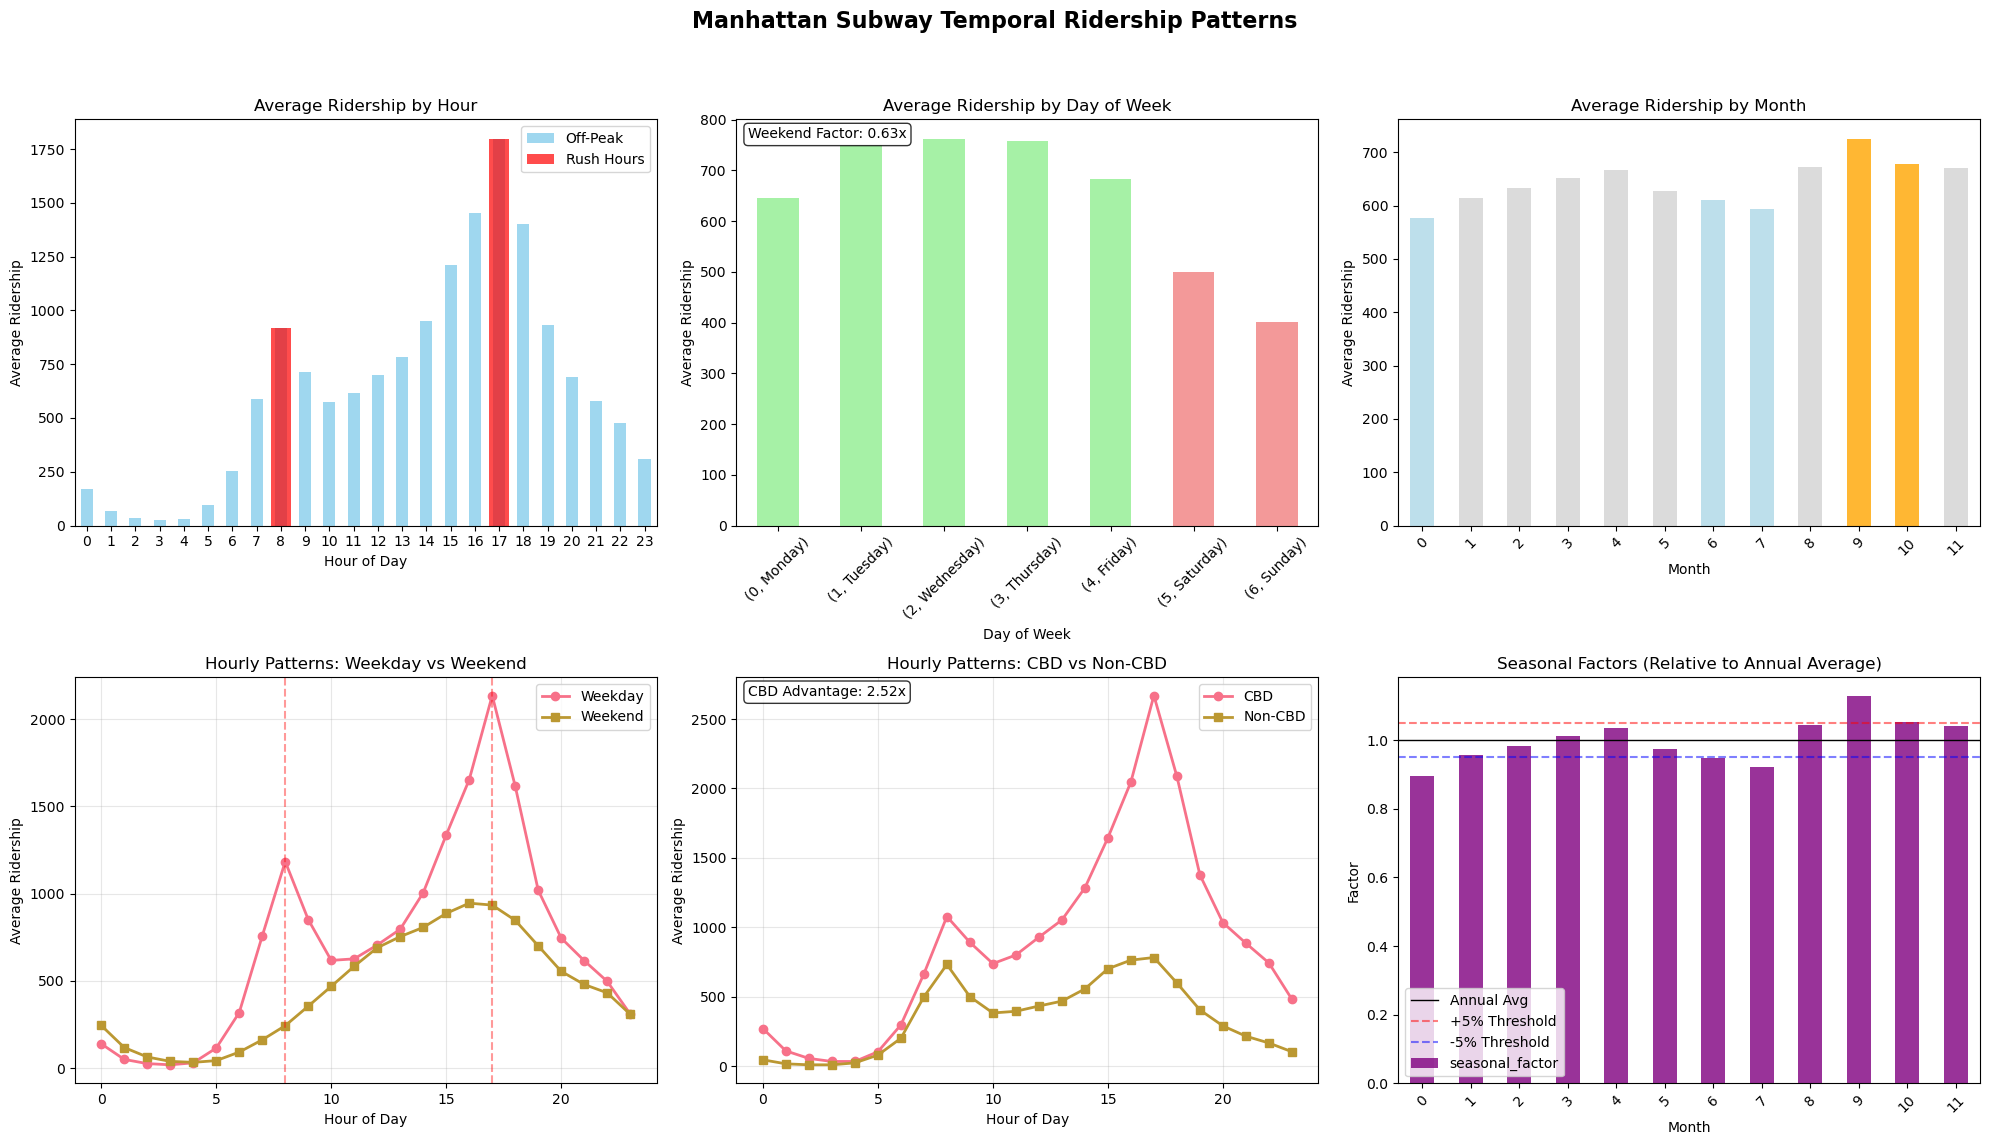

Temporal pattern visualizations completed.


In [8]:
# =========================================
# 6. TEMPORAL PATTERN VISUALIZATIONS
# =========================================

print("\n" + "=" * 60)
print("6. TEMPORAL PATTERN VISUALIZATIONS")
print("=" * 60)

# Create 6-panel plot
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Manhattan Subway Temporal Ridership Patterns', fontsize=16, fontweight='bold')

# 1. Hourly patterns with rush hour highlighting
hourly_patterns['avg_ridership'].plot(kind='bar', ax=axes[0, 0], color='skyblue', alpha=0.8)
for hour in rush_hours:
    axes[0, 0].bar(hour, hourly_patterns.loc[hour, 'avg_ridership'], color='red', alpha=0.7)
axes[0, 0].set_title('Average Ridership by Hour')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Average Ridership')
axes[0, 0].tick_params(axis='x', rotation=0)
axes[0, 0].legend(['Off-Peak', 'Rush Hours'])

# 2. Day of week patterns
daily_colors = ['lightcoral' if day in [5, 6] else 'lightgreen' for day in daily_patterns.index.get_level_values(0)]
daily_patterns['avg_ridership'].plot(kind='bar', ax=axes[0, 1], color=daily_colors, alpha=0.8)
axes[0, 1].set_title('Average Ridership by Day of Week')
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('Average Ridership')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].text(0.02, 0.98, f'Weekend Factor: {weekend_factor:.2f}x',
                transform=axes[0, 1].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 3. Monthly average ridership with seasonal classification
monthly_colors = []
for month in monthly_patterns['month_name']:
    if month in high_months:
        monthly_colors.append('orange')
    elif month in low_months:
        monthly_colors.append('lightblue')
    else:
        monthly_colors.append('lightgray')

monthly_patterns['avg_ridership'].plot(kind='bar', ax=axes[0, 2], color=monthly_colors, alpha=0.8)
axes[0, 2].set_title('Average Ridership by Month')
axes[0, 2].set_xlabel('Month')
axes[0, 2].set_ylabel('Average Ridership')
axes[0, 2].tick_params(axis='x', rotation=45)

# 4. Hourly comparison (weekday vs weekend)
axes[1, 0].plot(hourly_comparison.index, hourly_comparison['weekday_avg'], label='Weekday', marker='o', linewidth=2)
axes[1, 0].plot(hourly_comparison.index, hourly_comparison['weekend_avg'], label='Weekend', marker='s', linewidth=2)
axes[1, 0].set_title('Hourly Patterns: Weekday vs Weekend')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Average Ridership')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
for hour in rush_hours:
    axes[1, 0].axvline(x=hour, color='red', linestyle='--', alpha=0.4)

# 5. CBD vs Non-CBD hourly ridership
if 'is_cbd' in df.columns and 'CBD_avg' in cbd_comparison.columns:
    axes[1, 1].plot(cbd_comparison.index, cbd_comparison['CBD_avg'], label='CBD', marker='o', linewidth=2)
    axes[1, 1].plot(cbd_comparison.index, cbd_comparison['Non_CBD_avg'], label='Non-CBD', marker='s', linewidth=2)
    axes[1, 1].set_title('Hourly Patterns: CBD vs Non-CBD')
    axes[1, 1].set_xlabel('Hour of Day')
    axes[1, 1].set_ylabel('Average Ridership')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    cbd_adv = analysis_results.get("cbd_patterns", {}).get("cbd_advantage", 0)
    axes[1, 1].text(0.02, 0.98, f'CBD Advantage: {cbd_adv:.2f}x',
                   transform=axes[1, 1].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
else:
    axes[1, 1].text(0.5, 0.5, 'CBD Data\nNot Available', ha='center', va='center',
                   transform=axes[1, 1].transAxes, fontsize=12)
    axes[1, 1].set_title('CBD vs Non-CBD Patterns')
    axes[1, 1].axis('off')

# 6. Seasonal factors bar chart
monthly_patterns['seasonal_factor'].plot(kind='bar', ax=axes[1, 2], color='purple', alpha=0.8)
axes[1, 2].axhline(1.0, color='black', linestyle='-', linewidth=1, label='Annual Avg')
axes[1, 2].axhline(1.05, color='red', linestyle='--', alpha=0.5, label='+5% Threshold')
axes[1, 2].axhline(0.95, color='blue', linestyle='--', alpha=0.5, label='-5% Threshold')
axes[1, 2].set_title('Seasonal Factors (Relative to Annual Average)')
axes[1, 2].set_xlabel('Month')
axes[1, 2].set_ylabel('Factor')
axes[1, 2].tick_params(axis='x', rotation=45)
axes[1, 2].legend()

# Final layout and display
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
print("Temporal pattern visualizations completed.")


In [9]:
# =============================================
# 7. HOLIDAY AND SPECIAL EVENT DETECTION
# =============================================

print("\n" + "=" * 60)
print("7. HOLIDAY AND SPECIAL EVENT DETECTION")
print("=" * 60)

# Try importing US holidays
try:
    import holidays
    us_holidays = holidays.US(years=2024)
    holidays_2024 = {date.strftime('%Y-%m-%d'): name for date, name in us_holidays.items()}
    print(f"Using holidays package: {len(holidays_2024)} holidays detected")
except ImportError:
    print("Holidays package not available, using hardcoded federal holidays")
    holidays_2024 = {
        '2024-01-01': "New Year's Day",
        '2024-01-15': "Martin Luther King Jr. Day",
        '2024-02-19': "Presidents Day",
        '2024-05-27': "Memorial Day",
        '2024-06-19': "Juneteenth",
        '2024-07-04': "Independence Day",
        '2024-09-02': "Labor Day",
        '2024-10-14': "Columbus Day",
        '2024-11-11': "Veterans Day",
        '2024-11-28': "Thanksgiving Day",
        '2024-12-25': "Christmas Day"
    }

print("\nRecognized Holidays for 2024:")
for date, name in sorted(holidays_2024.items()):
    print(f"- {date}: {name}")

# Create holiday indicators
df['date_str'] = df['transit_timestamp'].dt.strftime('%Y-%m-%d')
df['is_holiday'] = df['date_str'].isin(holidays_2024).astype('int64')
df['holiday_name'] = df['date_str'].map(holidays_2024).fillna('Non-Holiday')

# Measure coverage
holiday_hours = df['is_holiday'].sum()
expected_holiday_hours = len(holidays_2024) * 24
holiday_coverage_pct = (holiday_hours / expected_holiday_hours) * 100 if expected_holiday_hours else 0

print(f"\nHoliday Coverage:")
print(f"- Observed holiday hours: {holiday_hours}")
print(f"- Expected holiday hours: {expected_holiday_hours}")
print(f"- Holiday data coverage: {holiday_coverage_pct:.1f}%")

# Begin analysis if holidays are present
if holiday_hours > 0:
    holiday_df = df[df['is_holiday'] == 1].copy()
    holiday_stats = holiday_df.groupby(['date_str', 'holiday_name'])['ridership'].agg(['sum', 'mean', 'count']).round(0)
    holiday_stats.columns = ['total_ridership', 'avg_ridership', 'record_count']

    # Compare holiday vs. normal ridership
    holiday_avg = holiday_df['ridership'].mean()
    normal_avg = df[df['is_holiday'] == 0]['ridership'].mean()
    holiday_factor = holiday_avg / normal_avg if normal_avg > 0 else 1.0
    impact_pct = (1 - holiday_factor) * 100

    print(f"\nHoliday Impact Summary:")
    print(f"- Average ridership on holidays: {holiday_avg:.0f}")
    print(f"- Average ridership on non-holidays: {normal_avg:.0f}")
    print(f"- Holiday factor: {holiday_factor:.2f}x")
    print(f"- Impact compared to normal: {impact_pct:+.1f}%")

    print("\nHoliday Ridership Breakdown:")
    print(holiday_stats.sort_values('avg_ridership'))

    # Classify holidays by impact
    threshold_high = normal_avg * 0.8
    threshold_med = normal_avg * 0.9

    high_impact = holiday_stats[holiday_stats['avg_ridership'] <= threshold_high]
    medium_impact = holiday_stats[(holiday_stats['avg_ridership'] > threshold_high) & (holiday_stats['avg_ridership'] <= threshold_med)]
    low_impact = holiday_stats[holiday_stats['avg_ridership'] > threshold_med]

    print(f"\nHoliday Classification:")
    print(f"- High impact (≤80% of normal): {len(high_impact)}")
    print(f"- Medium impact (80–90% of normal): {len(medium_impact)}")
    print(f"- Low impact (>90% of normal): {len(low_impact)}")

    # Identify extremes
    most_impact = holiday_stats['avg_ridership'].idxmin()
    least_impact = holiday_stats['avg_ridership'].idxmax()

    print(f"\nExtreme Holiday Impacts:")
    print(f"- Most disruptive: {most_impact[1]} ({holiday_stats.loc[most_impact, 'avg_ridership']:.0f})")
    print(f"- Least disruptive: {least_impact[1]} ({holiday_stats.loc[least_impact, 'avg_ridership']:.0f})")

    # Compare to weekend average
    weekend_avg = df[df['is_weekend'] == 1]['ridership'].mean()
    holiday_vs_weekend = holiday_avg / weekend_avg if weekend_avg > 0 else 1.0

    print(f"\nHoliday vs. Weekend Comparison:")
    print(f"- Weekend average: {weekend_avg:.0f}")
    print(f"- Holiday/weekend ratio: {holiday_vs_weekend:.2f}x")

    # Save results
    analysis_results['holiday_patterns'] = {
        'holiday_avg': float(holiday_avg),
        'normal_avg': float(normal_avg),
        'weekend_avg': float(weekend_avg),
        'holiday_factor': float(holiday_factor),
        'holiday_vs_weekend': float(holiday_vs_weekend),
        'impact_pct': float(impact_pct),
        'holiday_coverage_pct': float(holiday_coverage_pct),
        'num_holidays': len(holiday_stats),
        'high_impact': len(high_impact),
        'medium_impact': len(medium_impact),
        'low_impact': len(low_impact)
    }

else:
    print("No valid holiday records found in this dataset.")
    analysis_results['holiday_patterns'] = {
        'holiday_avg': 0,
        'normal_avg': float(df['ridership'].mean()),
        'weekend_avg': float(df[df['is_weekend'] == 1]['ridership'].mean()),
        'holiday_factor': 1.0,
        'holiday_vs_weekend': 1.0,
        'impact_pct': 0.0,
        'holiday_coverage_pct': 0.0,
        'num_holidays': 0,
        'high_impact': 0,
        'medium_impact': 0,
        'low_impact': 0
    }

print("\nHoliday analysis completed.")



7. HOLIDAY AND SPECIAL EVENT DETECTION
Using holidays package: 11 holidays detected

Recognized Holidays for 2024:
- 2024-01-01: New Year's Day
- 2024-01-15: Martin Luther King Jr. Day
- 2024-02-19: Washington's Birthday
- 2024-05-27: Memorial Day
- 2024-06-19: Juneteenth National Independence Day
- 2024-07-04: Independence Day
- 2024-09-02: Labor Day
- 2024-10-14: Columbus Day
- 2024-11-11: Veterans Day
- 2024-11-28: Thanksgiving Day
- 2024-12-25: Christmas Day

Holiday Coverage:
- Observed holiday hours: 31600
- Expected holiday hours: 264
- Holiday data coverage: 11969.7%

Holiday Impact Summary:
- Average ridership on holidays: 427
- Average ridership on non-holidays: 650
- Holiday factor: 0.66x
- Impact compared to normal: +34.4%

Holiday Ridership Breakdown:
                                                 total_ridership  \
date_str   holiday_name                                            
2024-12-25 Christmas Day                                  821550   
2024-11-28 Thanksgiv

In [10]:
# =============================================
# 8. FEATURE ENGINEERING INSIGHTS & RECOMMENDATIONS
# =============================================

print("\n" + "=" * 60)
print("8. FEATURE ENGINEERING INSIGHTS AND RECOMMENDATIONS")
print("=" * 60)

print("Recommended engineered features for predictive modeling:\n")

# 1. Cyclical time encodings
print("CYCLICAL ENCODING FEATURES:")
print("• hour_sin / hour_cos          → 24-hour cycle (rush patterns)")
print("• day_of_week_sin / cos        → Weekly cycle (weekday/weekend)")
print("• month_sin / month_cos        → Seasonal cycle")
print()

# 2. Binary / categorical
print("KEY BINARY FEATURES:")
print(f"• is_rush_hour                 → {rush_hours} (rush factor: {rush_factor:.2f}x)")
print("• is_weekend                   → Saturday/Sunday")
print("• is_holiday                   → Federal holidays")
if 'is_cbd' in df.columns:
    cbd_factor = analysis_results['cbd_patterns']['cbd_advantage']
    print(f"• is_cbd                       → CBD stations (advantage: {cbd_factor:.2f}x)")
print()

# 3. Temporal refinements
print("TEMPORAL DETAIL FEATURES:")
print(f"• is_am_rush                   → AM rush: {am_rush}")
print(f"• is_pm_rush                   → PM rush: {pm_rush}")
print("• is_weekday_rush              → Weekday × rush hour")
print("• day_name                     → Full weekday name (categorical)")
print()

# 4. Holiday & seasonal categories
print("HOLIDAY IMPACT FEATURES:")
print("• is_major_holiday             → High-impact holidays (≤80% ridership)")
print("• is_working_holiday           → Low-impact holidays (>90%)")
print("• holiday_severity             → Categorical (high/med/low)")
print()

print("SEASONAL FEATURES:")
season_range = monthly_patterns['seasonal_factor'].max() - monthly_patterns['seasonal_factor'].min()
print(f"• seasonal_factor              → Monthly multiplier ({season_range:.2f} range)")
print(f"• is_fall_peak                 → {high_months}")
print(f"• is_summer_low                → {low_months}")
print("• season                       → Spring/Summer/Fall/Winter")
print()

# 5. Station-level patterns
if 'is_cbd' in df.columns:
    print("STATION-LEVEL FEATURES:")
    peak_types = analysis_results['station_temporal']
    print(f"• station_peak_type            → AM ({peak_types['am_peak_stations']}), PM ({peak_types['pm_peak_stations']}), Off-peak")
    print(f"• station_ridership_tier       → Range: {peak_types['station_range_factor']:.1f}x busiest to quietest")
    print()

# 6. Critical interactions
print("INTERACTION FEATURES:")
print("• weekday_rush                 → is_rush_hour × ~is_weekend")
print("• weekend_late_night           → is_weekend × hour ∈ [0–3]")
if 'is_cbd' in df.columns:
    print("• cbd_evening_rush             → is_cbd × is_pm_rush")
    print("• cbd_late_night               → is_cbd × late hours (0–3)")
print("• holiday_type_hour            → holiday_severity × hour")
print()

# 7. Advanced time-dynamic features
print("ADVANCED TEMPORAL FEATURES:")
print("• hour_weekend_ratio           → Weekend-to-weekday by hour")
print("• cbd_hour_multiplier          → Hour-level CBD advantage")
print("• peak_intensity               → Distance from rush peak (e.g., sigmoid or 1 - abs(hour - peak))")
print("• weekend_nightlife            → Weekend late-night indicator")
print()

# Quantified effect summary
print("QUANTIFIED IMPACTS:")
print(f"• Rush hour factor             → {rush_factor:.2f}x ({(rush_factor - 1)*100:+.0f}%)")
print(f"• Weekend factor               → {weekend_factor:.2f}x")
print(f"• Holiday factor               → {holiday_factor:.2f}x")
if 'is_cbd' in df.columns:
    print(f"• CBD premium                  → {cbd_factor:.2f}x")
print(f"• Seasonal range               → {season_range*100:.1f} percentage points")
print(f"• Station range factor         → {peak_types['station_range_factor']:.1f}x")

# Recommendation sets
feature_recommendations = {
    'critical_features': [
        'hour_sin', 'hour_cos',
        'is_weekend', 'is_rush_hour',
        'is_cbd' if 'is_cbd' in df.columns else None
    ],
    'high_importance_features': [
        'day_of_week_sin', 'day_of_week_cos',
        'is_holiday', 'seasonal_factor', 'weekday_rush'
    ],
    'medium_importance_features': [
        'month_sin', 'month_cos',
        'is_fall_peak', 'is_summer_low',
        'holiday_severity',
        'cbd_evening_rush' if 'is_cbd' in df.columns else None
    ],
    'advanced_interaction_features': [
        'weekend_late_night',
        'cbd_late_night' if 'is_cbd' in df.columns else None,
        'hour_weekend_ratio',
        'cbd_hour_multiplier' if 'is_cbd' in df.columns else None
    ]
}
# Clean None values
feature_recommendations = {
    k: [f for f in v if f is not None] for k, v in feature_recommendations.items()
}
analysis_results['feature_recommendations'] = feature_recommendations

# Output feature rankings
print("\nFEATURE PRIORITY RANKINGS:")
for tier, features in feature_recommendations.items():
    label = tier.replace("_", " ").title()
    print(f"• {label}: {features}")

# Strategic modeling plan
print("\nMODELING STRATEGY:")
print("1. Start with critical time + location features")
print("2. Add seasonal and holiday variables")
print("3. Add station patterns and interactions")
print("4. Use advanced temporal interactions if needed")

print("\nFeature engineering insights compiled and stored.")



8. FEATURE ENGINEERING INSIGHTS AND RECOMMENDATIONS
Recommended engineered features for predictive modeling:

CYCLICAL ENCODING FEATURES:
• hour_sin / hour_cos          → 24-hour cycle (rush patterns)
• day_of_week_sin / cos        → Weekly cycle (weekday/weekend)
• month_sin / month_cos        → Seasonal cycle

KEY BINARY FEATURES:
• is_rush_hour                 → [8, 17] (rush factor: 2.36x)
• is_weekend                   → Saturday/Sunday
• is_holiday                   → Federal holidays
• is_cbd                       → CBD stations (advantage: 2.52x)

TEMPORAL DETAIL FEATURES:
• is_am_rush                   → AM rush: [8]
• is_pm_rush                   → PM rush: [17]
• is_weekday_rush              → Weekday × rush hour
• day_name                     → Full weekday name (categorical)

HOLIDAY IMPACT FEATURES:
• is_major_holiday             → High-impact holidays (≤80% ridership)
• is_working_holiday           → Low-impact holidays (>90%)
• holiday_severity             → Categorica

In [11]:
# =============================================
# 9. SAVE TEMPORAL ANALYSIS RESULTS
# =============================================

print("\n" + "=" * 60)
print("9. SAVING TEMPORAL ANALYSIS RESULTS")
print("=" * 60)

# Save essential summaries only (skip plots, raw data)
TEMPORAL_PATTERNS_FILE = ANALYSIS_DIR / "temporal_patterns.json"

essential_results = {
    'analysis_metadata': {
        'analysis_date': datetime.now().isoformat(),
        'source_dataset': str(INTEGRATED_FILE),
        'analysis_type': 'temporal_pattern_analysis'
    },
    'key_patterns': {
        'rush_hours': rush_hours,
        'rush_factor': float(rush_factor),
        'weekend_factor': float(weekend_factor),
        'holiday_factor': float(holiday_factor),
        'cbd_advantage': float(analysis_results['cbd_patterns']['cbd_advantage']),
        'seasonal_range': float(monthly_patterns['seasonal_factor'].max() - monthly_patterns['seasonal_factor'].min())
    },
    'monthly_factors': {
        row['month_name']: float(row['seasonal_factor'])
        for _, row in monthly_patterns.iterrows()
    },
    'feature_priorities': analysis_results['feature_recommendations']
}

# Write to JSON
with open(TEMPORAL_PATTERNS_FILE, 'w') as f:
    json.dump(essential_results, f, indent=2)

print(f"Saved pattern summary: {TEMPORAL_PATTERNS_FILE.name}")

# Summary
print("\n" + "=" * 60)
print("TEMPORAL PATTERN ANALYSIS COMPLETED")
print("=" * 60)
print("Key Insights:")
print(f"• Rush hour factor:       {rush_factor:.2f}x ({(rush_factor - 1) * 100:+.0f}%)")
print(f"• Weekend factor:         {weekend_factor:.2f}x ({(weekend_factor - 1) * 100:+.0f}%)")
print(f"• Holiday factor:         {holiday_factor:.2f}x ({(holiday_factor - 1) * 100:+.0f}%)")
print(f"• CBD location premium:   {analysis_results['cbd_patterns']['cbd_advantage']:.2f}x")
print(f"• Seasonal range:         {(essential_results['key_patterns']['seasonal_range'] * 100):.0f} percentage points")

print("\nAnalysis outputs are ready for feature engineering and weather correlation.")



9. SAVING TEMPORAL ANALYSIS RESULTS
Saved pattern summary: temporal_patterns.json

TEMPORAL PATTERN ANALYSIS COMPLETED
Key Insights:
• Rush hour factor:       2.36x (+136%)
• Weekend factor:         0.63x (-37%)
• Holiday factor:         0.66x (-34%)
• CBD location premium:   2.52x
• Seasonal range:         23 percentage points

Analysis outputs are ready for feature engineering and weather correlation.
